In [1]:
from google.colab import drive
drive.mount('/content/gdrive') # .experiments

Mounted at /content/gdrive


In [2]:
!cp -r '/content/gdrive/My Drive/Colab Notebooks/ssvep' /content
!pip install mat73

## Channel info in mat files

1. CH1: sample time
2. CH2- 9: EEG
3. CH10: trigger info
4. CH11: LDA classification output

## Sampling Rate: 256Hz
## Labels: classinfo_4_5.m

In [3]:
with open('ssvep/classInfo_4_5.m') as f:
    targets_str= f.read().split('\n')

targets=[]
for label in targets_str[:-1]:
    targets.append(list(map(int,label.split(' '))))

In [4]:
import mat73

subject= 1
sub1_train1_data = f'ssvep/subject_1_fvep_led_training_1.mat'
sub1_train2_data = f'ssvep/subject_1_fvep_led_training_2.mat'
sub2_train1_data = f'ssvep/subject_2_fvep_led_training_1.mat'
sub2_train2_data = f'ssvep/subject_2_fvep_led_training_2.mat'

data_dict_sub1_train1 = mat73.loadmat(sub1_train1_data)
data_dict_sub1_train2 = mat73.loadmat(sub1_train2_data)
data_dict_sub2_train1 = mat73.loadmat(sub2_train1_data)
data_dict_sub2_train2 = mat73.loadmat(sub2_train2_data)

print(data_dict_sub1_train1.keys(), data_dict_sub1_train2.keys(), data_dict_sub2_train1.keys(), data_dict_sub2_train2.keys())

data_sub1_train1 = data_dict_sub1_train1['y']
data_sub1_train2 = data_dict_sub1_train2['y']
data_sub2_train1 = data_dict_sub2_train1['y']
data_sub2_train2 = data_dict_sub2_train2['y']

print(data_sub1_train1.shape, data_sub1_train2.shape, data_sub2_train1.shape, data_sub2_train2.shape)

dict_keys(['y']) dict_keys(['y']) dict_keys(['y']) dict_keys(['y'])
(11, 57728) (11, 58112) (11, 58757) (11, 57697)


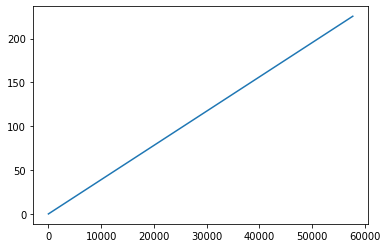

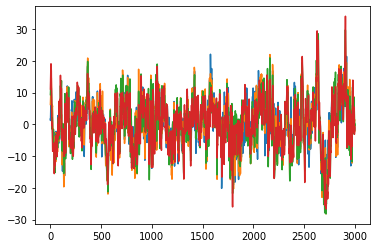

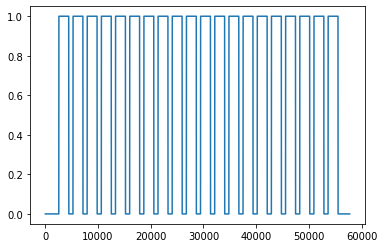

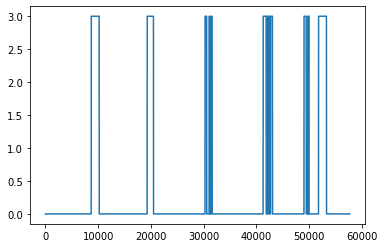

In [5]:
data = data_sub1_train1

import matplotlib.pyplot as plt

plt.plot(data[0])
plt.show()
plt.plot(data[1][10000:13000])
plt.plot(data[2][10000:13000])
plt.plot(data[3][10000:13000])
plt.plot(data[4][10000:13000])
plt.show()

plt.plot(data[9])
plt.show()
plt.plot(data[10])
plt.show()

In [6]:
data[0, -1]

225.49609375

In [7]:
data.shape[1]

57728

In [8]:
data.shape[1]/ data[0, -1] *3

768.0133039998614

In [9]:
print((data_sub1_train1[10]==0).sum(), (data_sub1_train1[10]==1).sum(), (data_sub1_train1[10]==2).sum(), (data_sub1_train1[10]==3).sum(), (data_sub1_train1[10]==4).sum())
print((data_sub1_train2[10]==0).sum(), (data_sub1_train2[10]==1).sum(), (data_sub1_train2[10]==2).sum(), (data_sub1_train2[10]==3).sum(), (data_sub1_train2[10]==4).sum())
print((data_sub2_train1[10]==0).sum(), (data_sub2_train1[10]==1).sum(), (data_sub2_train1[10]==2).sum(), (data_sub2_train1[10]==3).sum(), (data_sub2_train1[10]==4).sum())
print((data_sub2_train2[10]==0).sum(), (data_sub2_train2[10]==1).sum(), (data_sub2_train2[10]==2).sum(), (data_sub2_train2[10]==3).sum(), (data_sub2_train2[10]==4).sum())

51072 0 0 6656 0
50832 156 0 6344 780
32289 5408 4212 1768 15080
29097 3328 2912 2548 19812


In [10]:
import numpy as np
def get_trigger_intervals(data):
    intervals_start= []
    intervals_end= []

    for i in range(0,len(data[9])-1):
        if data[9,i]==0 and data[9,i+1]==1:
            intervals_start.append(i+1)
        if data[9,i]==1 and data[9,i+1]==0:
            intervals_end.append(i+1)
    assert len(intervals_start)== len(intervals_end)

    import numpy as np
    intervals = np.array([intervals_start, intervals_end]).T

    return intervals

def get_label_array(data):
    intervals = get_trigger_intervals(data) 
    labels = np.zeros((data.shape[1]))
    class_=1
    for interval in intervals:
        labels[interval[0]:interval[1]]= class_
        class_+=1
        if class_==5:class_=1
    return labels

def get_samples(data_channel, intervals):
    output = []
    if len(data_channel.shape)==1:
        for interval in intervals:
            output.append(data_channel[interval[0]: interval[1]])
    
    elif len(data_channel.shape)==2:
        for interval in intervals:
            output.append(data_channel[:,interval[0]: interval[1]])
    return np.array(output)

def create_dataset(sample_eeg, sample_labels, window_size=10):
    eegs=[]
    labels=[]
    for idx in range(len(sample_eeg)):
        eeg_chunk = sample_eeg[idx]
        label_chunk= sample_labels[idx]
        for i in range(0, eeg_chunk.shape[1]- window_size, window_size):
            eegs.append(eeg_chunk[:,i:i+window_size])
            labels.append(label_chunk[i])
    return np.array(eegs), np.array(labels)


In [11]:
intervals = get_trigger_intervals(data)
#print(intervals)
labels = get_label_array(data)

samples_labels= get_samples(labels, intervals)
samples_lda_preds= get_samples(data[10], intervals)
samples_eeg= get_samples(data[1:9], intervals)

eegs,labels = create_dataset(samples_eeg, samples_labels, window_size=768) # window_size -> timestamps

In [12]:
eegs.shape

(40, 8, 768)

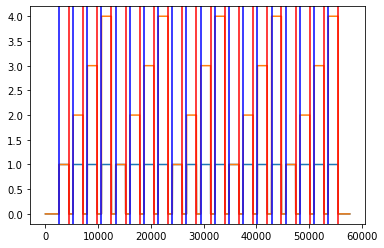

In [13]:
plt.plot(data[9])
plt.plot(get_label_array(data))
for interval in intervals:
    plt.axvline(x=interval[0], color='b')
    plt.axvline(x=interval[1], color= 'r')

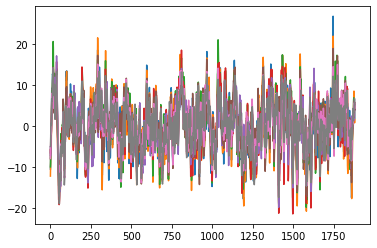

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


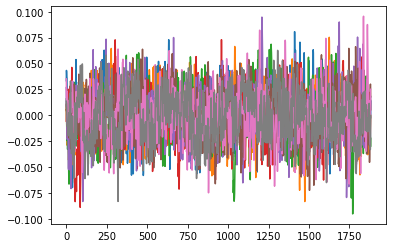

In [14]:
from scipy import signal
from sklearn.decomposition import FastICA, PCA

one_set = np.c_[samples_eeg[-10,0],samples_eeg[-10,1],samples_eeg[-10,2],samples_eeg[-10,3],samples_eeg[-10,4],samples_eeg[-10,5],samples_eeg[-10,6],samples_eeg[-10,7]]
plt.plot(one_set)
plt.show()

ica = FastICA(n_components=8)
S_ = ica.fit_transform(one_set)
plt.plot(S_)
plt.show()

In [15]:
import scipy.signal

b1, a1 =scipy.signal.butter(N=7, Wn=[0.5, 30], btype='bandpass', fs=256)
b2, a2 =scipy.signal.iirnotch(w0= 50, Q=30, fs=256)

8.977683315621679


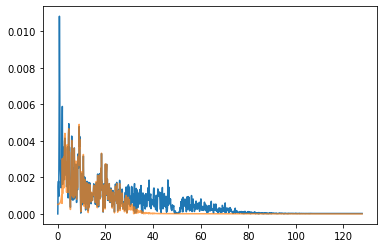

8.977683315621679


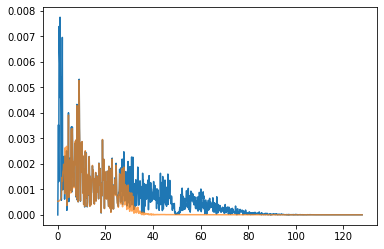

3.8087141339001063


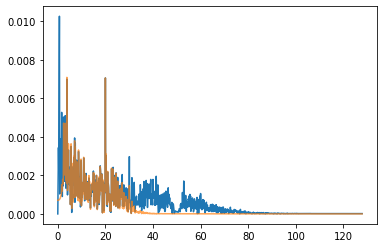

10.065887353878852


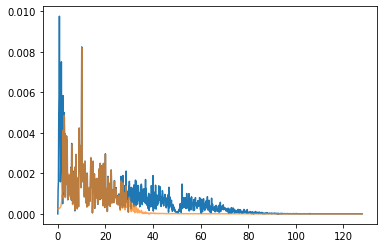

19.995749202975556


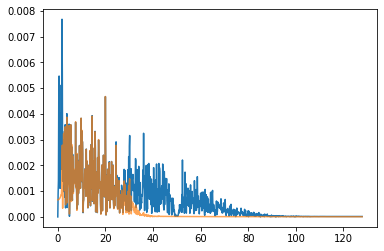

7.7534537725823585


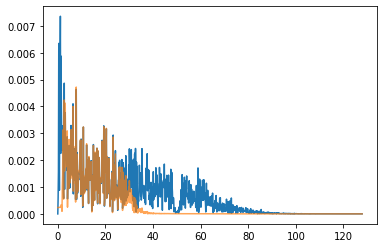

9.929861849096705


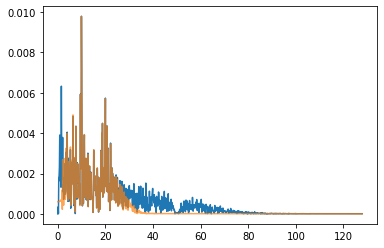

3.1285866099893727


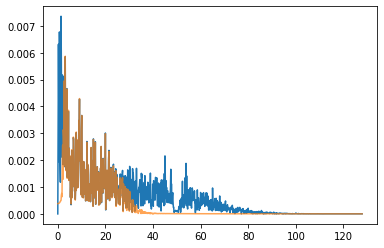

[0, 1, 3, 5, 6]


In [16]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

idx_list = []
chunk = -2
for idx in range(8):
    #y = samples_eeg[chunk,idx]
    y = S_[:,idx]
    N = len(y)
    T = 1.0 / 256.0
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.grid()
    #plt.show()

    b1, a1 =scipy.signal.butter(N=6, Wn=[2, 30], btype='bandpass', fs=256)
    #y = scipy.signal.filtfilt(b1, a1, samples_eeg[chunk,idx])
    y = scipy.signal.filtfilt(b1, a1, S_[:,idx] )
    N = len(y)
    T = 1.0 / 256.0
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), alpha=0.7)
    arr= 2.0/N * np.abs(yf[0:N//2])
    print(xf[list(arr).index(np.max(arr))])
    
    if 7 < (xf[list(arr).index(np.max(arr))]) < 17:
      idx_list.append(idx)


    plt.grid()
    plt.show()
print(idx_list)